# Graph Theory (Network Analysis)
(credits: Moses Marsh, Matt Drury, Jonathan Torrez, Ivan Corneillet)

## Installation Instructions:

You may need to install the following modules and utilities to get this notebook to run

```
pip install nxpd
brew install graphviz (macOS) or sudo apt-get graphviz (Linux)

git clone https://github.com/taynaud/python-louvain/
cd python-louvain
python setup.py install
```

## Morning Lecture

### Objectives

- Describe the formal definition of a graph
- Describe the most common data structures used to represent graphs
- Contrast the strengths of the most common data structures used to represent graphs
- List common applications of graphs
  - Social Network Analysis
  - Data structures
- Define basic graph concepts
  - Degree
  - Neighbors
  - Path
  - Cycle
  - Components
- Describe types of graphs
  - Connected vs. disconnected
  - Directed vs. undirected
  - Weighted vs. unweighted
  - Trees
- State common search algorithms for graphs
- Contrast BFS and DFS algorithms
- Describe data structures used for BFS vs. DFS
    - Stack
    - Queue
- Write pseudocode for BFS of graph
- Describe use of BFS to find shortest path in graph

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from collections import deque
from itertools import product

# Standard Python Library for working with graphs
import networkx as nx

# Helper library to visualize graphs
import nxpd

# Helper library for community related functions
import community

# Custom module that Matt wrote
import GraphTools as gt

plt.style.use('ggplot')
%matplotlib inline

## What is a graph?
A graph is a **network**, an abstraction of relationships between data points.
![](images/undirected_graph.png)
Data points are **nodes** (or **vertices**), and the connections between them are **edges**. 

Maybe the nodes are people and the edges represent friendship. [Here's](https://github.com/gschool/dsi-welcome/blob/master/readings/Social_Network_Analysis_for_Startups.pdf) a whole book on analyzing **social networks** using graphs.

### A social graph from Facebook:

![Facebook Social Graph](images/facebook-social-graph.jpg)

- **Nodes** are facebook profiles
- **Edges** are friend connections

### Game of thrones

![](images/game_of_thrones.png)
source: https://www.maa.org/sites/default/files/pdf/Mathhorizons/NetworkofThrones%20(1).pdf



### Computer connectivity across the Internet:

![Internet](images/internet.png)

- **Nodes** are computers
- **Edges** are direct connections from one computer to another
source: http://www.opte.org/the-internet/



### Paris' Metro:

![Paris' Metro](images/paris-metro.gif)

- **Nodes** are subway stations
- **Edges** are subway connections

Graphs are mathematical abstractions; the pictures are only there to help our brains comprehend the data.

The **actual** Paris subway's geographic structure look like this:

![Geographically Accurate Metro Map](images/paris-metro-geo.jpg)


### Food web

![](images/food_web.png)
[source](https://www.flickr.com/photos/121935927@N06/13578885414)

### What kinds of relationships can we represent?

![](images/directed-graph_2.png)
In a **directed graph**, edges represent one-way relationships (e.g. Twitter followers, phone calls)




![](images/airport_graph.gif)
In a **weighted graph**, edges also have a number (usually some kind of **cost**) associated with them.



## pair discussion
Can you think of something that could be represented by an undirected weighted graph?

### A bit of history
The original graph is the **Seven Bridges of Königsberg** ([wiki](https://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg)):

![Bridges of Konigsberg](images/konigsberg.png)
![](images/konigsberg_graph.png)

**Discussion:** Is it possible to walk around the city, crossing every bridge, but each *exactly* once?

Thanks, Euler!

### Back to formalities
Formally, a graph $G$ is:

- A set $N$ of **nodes**.  Nodes are abstract entities, can represent pretty much anything, and can have data attached
- A set $E$ of **edges**, which are directed or undirected pairs of nodes

The number of vertices (nodes) $|V|$ is the order of the graph.

The number of edges $|E|$ is the size of the graph.

So, for example:

$$N = \{1, 2, 3, 4, 5, 6 \}$$
$$E = \left\{ \{1, 2\}, \{1, 5\}, \{2, 3 \}, \{2, 4\}, \{3, 4\}, \{3, 6\}, \{4, 5\}, \{5\} \right\}$$

This does not tend to be a very efficient or useful representation though.

**Question:** What is the $\{ 5 \}$ communicating in the edge set?

### Basic Graph Concepts

The **neighbors** of a node are all those connected to it by an edge.

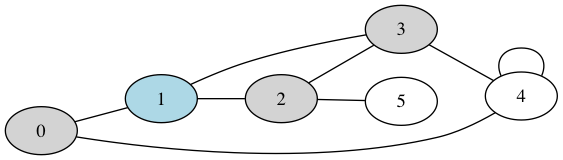

In [10]:
gt.color_nodes(G, [1], 'lightblue')
gt.color_nodes(G, G.neighbors(1), 'lightgrey')
nxpd.draw(G, show='ipynb')

The **degree** of a node is the number of neighbors it has.

$$d(0) = 2$$
$$d(1) = 3$$

A **path** is a series of edges that connect two nodes.

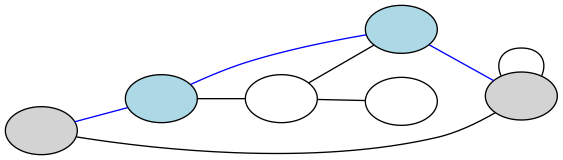

In [11]:
gt.reset_graph(G)
gt.color_nodes(G, [0, 4], 'lightgrey')
gt.color_nodes(G, [1, 3], 'lightblue')
gt.color_edges(G, [(0, 1), (1, 3), (3, 4)], 'blue')
nxpd.draw(G, show='ipynb')

A graph is **connected** if every pair of nodes is connected by some path.

A graph is **disconnected** if it is not connected.  In this case, each connected piece of the graph is called a **component**.

**Exercise:** Fill in the adjacency list for a *disconnected* graph, then plot it.

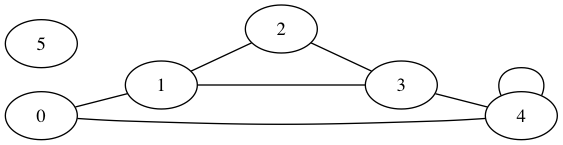

In [12]:
g_disconnected = {
    0: {1, 4},
    1: {0, 2, 3},
    2: {1, 3},
    3: {1, 2, 4},
    4: {0, 3, 4},
    5: {}
}

G_disconnected = nx.from_dict_of_lists(g_disconnected)
G_disconnected.graph['rankdir'] = 'LR'
nxpd.draw(G_disconnected, show='ipynb')

A **cycle** in a graph is a sequence of edges that returns to the same node from which it began:

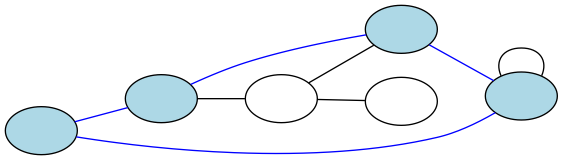

In [13]:
gt.reset_graph(G)
gt.color_nodes(G, [0, 1, 3, 4], 'lightblue')
gt.color_edges(G, [(0, 1), (1, 3), (3, 4), (4, 0)], 'blue')
nxpd.draw(G, show='ipynb')

A **tree** is a directed graph with no cycles.

In [16]:
def convert_adj_list_to_edge_list(adj_list):
    edge_list = set()
    for node, child_nodes in adj_list.iteritems():
        for child in child_nodes:
            edge_list.add((node, child))
    return edge_list

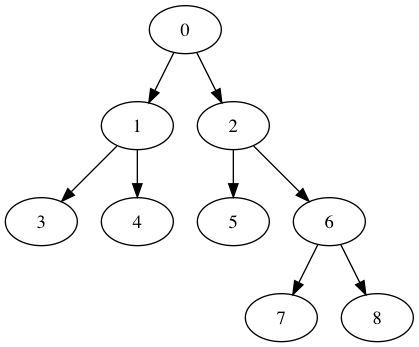

In [17]:
g_tree = {
    0: {1, 2},
    1: {3, 4},
    2: {5, 6},
    3: {},
    4: {},
    5: {},
    6: {7, 8},
    7: {},
    8: {}
}

g_tree_edge_list = convert_adj_list_to_edge_list(g_tree)

G_tree = nx.DiGraph()
G_tree.add_nodes_from(g_tree)
G_tree.add_edges_from(g_tree_edge_list)
nxpd.draw(G_tree, show='ipynb')

Trees are perhaps the most important types of graphs.  They are used as fundamental data structures in computer science:
- Hash tables
- Data bases
- Sorting Algorithms

### Data Structures for Graphs

There are three main data structures used for representing a graph.

- The **Adjacency matrix** representation creates a square matrix with rows and columns indexed by the nodes.  The entries in the matrix are either $0$ or $1$, depending on whether the nodes are linked with an edge.
  - PRO: Easy to understand and interpret
  - CON: "No edge" cells take up same amount of memory as other cells and most networks are low density (online social networks often have density of 0.1%)

- The **Edge list** representation lists the edges (and weights, if applicable)
  - PRO: Less space in memory for large and sparse networks
  - PRO: Maps easily into SQL databases
  - PRO: Maps easily into text based formats
  - CON: Searching/traversal of graph is slow (iterating over edges)

- The **Adjacency list** representation lists the nodes, and then the nodes lined to *that* node with an edge.
  - PRO: Less space in memory for large and sparse networks
  - PRO: Fast searching and traversal
  - PRO: Easy to add/remove nodes and edges
  - CON: Harder to parse from text
  - CON: Harder to write to databases

**Question:** Which data structure is best for persistent storage? Which data structure is best for internal data representation (working with the graph)?

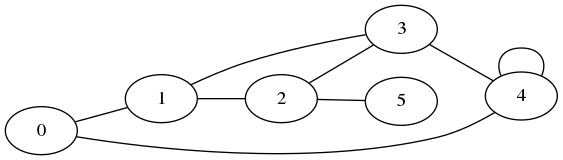

In [10]:
nxpd.draw(G, show='ipynb')

The *adjacency matrix* representation of the graph above is:

In [3]:
g_matrix = np.array([
    [0, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 1, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 0]
])

The *edge list* representation of the graph is:

In [4]:
g_edg = {
    (0, 1),
    (0, 4),
    (1, 0),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 3),
    (2, 5),
    (3, 1),
    (3, 2),
    (3, 4),
    (4, 0),
    (4, 3),
    (4, 4),
    (5, 2)
}

**Edge lists** may look useless, but consider how simple it would be to save and read in a file in edge list format, plus you can add a third field representing the weight of the edge.

The *adjacency list* representation of the above graph is:

In [5]:
g_adj = {
    0: {1, 4},
    1: {0, 2, 3},
    2: {1, 3, 5},
    3: {1, 2, 4},
    4: {0, 3, 4},
    5: {2}
}

The Python library's `networkx` and `nxpd` can be used to manipulate and visualize graphs.

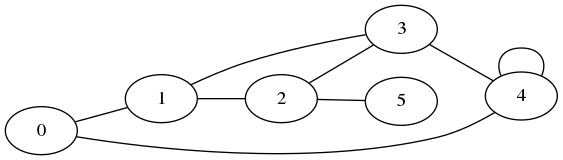

In [6]:
G = nx.from_dict_of_lists(g_adj)

# Draw left to right when possible, fits better in notebook
G.graph['rankdir'] = 'LR'

nxpd.draw(G, show='ipynb')

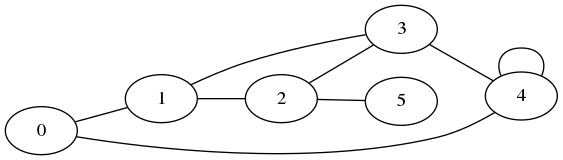

In [7]:
G = nx.Graph(g_matrix)
G.graph['rankdir'] = 'LR'
nxpd.draw(G, show='ipynb')

In [8]:
print 'G'

g_matrix

G


array([[0, 1, 0, 0, 1, 0],
       [1, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 0],
       [1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0]])

**Discussion:** If $G$ is the *adjacency matrix* of a graph, what graph does $G^2$ represent?

In [9]:
G2_arr = np.dot(g_matrix, g_matrix)
# Set all values greater than 0 to 1 since we only care about if there is an edge (1)
# or theres isn't an edge (0) in adj. matrices
G2_arr[G2_arr > 0] = 1
print "G^2"
G2_arr

G^2


array([[1, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 1]])

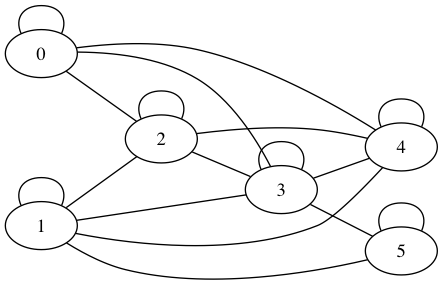

In [9]:
G2 = nx.Graph(G2_arr)
G2.graph['rankdir'] = 'LR'
nxpd.draw(G2, show='ipynb')

Exercise: adjacency matrix for a directed graph
![](images/directed-graph_2.png)


Exercise: adjacency matrix for a weighted graph
![](images/weighted_1.png)

### Search (Traversal) Algorithms

A **traversal algorithm** is a method for visiting every node in a graph.

A **search algorithm** is a method for searching for a specified node in a graph.

These two types of algorithms are almost interchangable: to turn a traversal algorithm into a search algorithm you simply need to provide a stopping criteria (in this case, the node you are searching for.

We will examine traversal algorithms to demonstrate the difference between the methods, but the same ideas apply to the search algorithms.

In **breadth first** algorithms we traverse the graph, prioritizing visiting all the *neighbours* of nodes before visiting *more neighbours*.

In **depth first** algorithms we traverse the graph, prioritizing visiting a *child* and the *child's child*, iteratively, before backtracking and visiting the *sibling* nodes.

We are using the term child loosely here, as there are no children in a graph, only neighbors.

**Intermission:** Review data structures.  **Stack** and **Queue**.

- Stack:
    - Ordering: Last In, First Out (LIFO)
    - Insertion/Removal of items: Same end of chain
    - Analogy: stack of dishes
- Queue:
    - Ordering: First In, First Out (FIFO) ordering
    - Insertion/Removal of items: Opposite ends of chain (insert at end, remove at front)
    - Analogy: line for movie premiere (if we were British, we'd already use the word queue instead of line)

**Discussion:** Which data structure should we use for breadth first algorithms? For depth first?

**Further Reading:** Python docs have short discussion of data structures to use for stacks and queues:
https://docs.python.org/2/tutorial/datastructures.html#data-structures

Breadth First Traversal (BFT) Pseudocode.

    Initialize a queue, Q, with starting node.
    Initialize an empty set *V* of visited nodes.

    While Q is not empty:
        Pop (earliest added) node from Q, call it node.
        if node is not already visited.
            Add node to V (the visited set).
            Add every neighbour of node to (the end of) Q.

Real code:

In [11]:
def breadth_first_traversal(G, initial_node):
    Q = deque([initial_node])

    # Using a list so I can preserve the order I visited nodes.
    visited = [] 

    while len(Q) != 0:
        node = Q.popleft() # pop from the left
        if node not in visited:
            visited.append(node)
            Q.extend(G.neighbors(node)) # extend to the right side

    return visited

We can label nodes by the search order to visualize the algorithm.

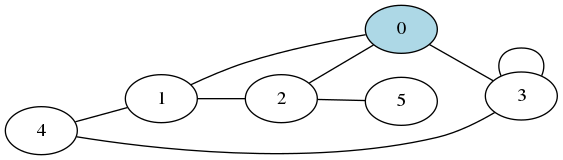

In [12]:
search_order = {v: i for i, v in
                enumerate(breadth_first_traversal(G, 3))}

gt.reset_graph(G)
gt.color_nodes(G, [3], 'lightblue')
gt.label_nodes(G, search_order)
nxpd.draw(G, show='ipynb')

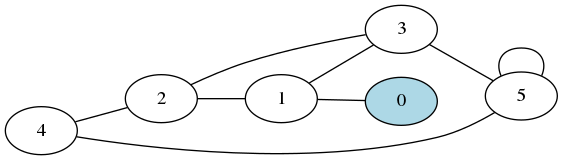

In [13]:
search_order = {v: i for i, v in
                enumerate(breadth_first_traversal(G, 5))}

gt.reset_graph(G)
gt.color_nodes(G, [5], 'lightblue')
gt.label_nodes(G, search_order)
nxpd.draw(G, show='ipynb')

**Question:** What information does the *order nodes are visited* in the breadth first traversal algorithm contain?

**Applications:**

- Shortest path in unweighted graph
- Crawlers in search engines
- Heaps

Today's sprint uses the ideas in this algorithm to compute the shortest path between two nodes.

Depth First Traversal (DFT) Pseudocode.

    Initiliaze a stack, S, with initial node
    Initialize an empty set *V* of visited nodes

    While S is not empty:
        Pop (last added) node from S, call it node
        if node is not already visited
            Add node to V (the visited set)
            Add every neighbor of node to (the end of) S

There are no children in graphs, only neighbors, but the concept of children is important in other graph structures such as trees.

In [14]:
# Implement the function below
# Use the pseudocode above and the code for the BFS we already used to guide you.
# Use a list for V to preserve the order we visit nodes.

def depth_first_traversal(graph, initial_node):
    pass

In [15]:
search_order = {v: i for i, v in
                enumerate(depth_first_traversal(G, 3))}
gt.reset_graph(G)
gt.color_nodes(G, [3], 'lightblue')
gt.label_nodes(G, search_order)
nxpd.draw(G, show='ipynb')

TypeError: 'NoneType' object is not iterable

**Applications:**

- Spanning tree of graph
- Solving a maze

## Afternoon Lecture

### Objectives

- State common centrality measures and why centrality is useful
- List common applications of centrality measures
- Solve for degree centrality and/or betweenness centrality of a node, given a graph
- Describe computing eigenvector centrality
- Contrast centrality measures
- Define community w/ respect to graphs
- Explain what modularity measures
- Use modularity to determine the "right" number of communities in a graph
- Write pseudocode for Girvan-Newman community detection algorithm
- Use appropriate package to build graphs and execute common graph algorithms

### Centrality Measures

Often it is important for us to measure the *importance* of a node in a graph.  There are **many** applications for different versions of this idea.

- Fraud rings in insurance claims
- Influencers
- Bottlenecks for network traffic
- Page Rank

### Degree Centrality

The **standardized degree centrality** measure of a node, $v$, in a graph is defined by:

$$\text{standardized_degree_centrality}(v) = \frac{\text{degree}(v)}{\text{number of nodes in } G - 1}$$

**Discussion:** Why subtract 1 from the total number of nodes to standardize? Why standardize at all?

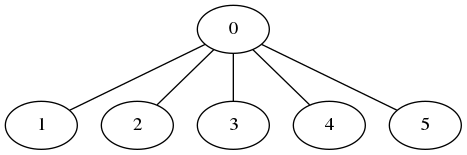

In [16]:
g_star = {
    0: {1, 2, 3, 4, 5},
    1: {0},
    2: {0},
    3: {0},
    4: {0},
    5: {0}
}

G_star = nx.from_dict_of_lists(g_star)
nxpd.draw(G_star, show='ipynb')

**Exercise:** Compute the degree centrality of the nodes in this graph.

*Hint*:  You should only have to compute the centrality of *two* nodes explicitly.

### Betweenness Centrality

While the *degree centrality* is intuitive and easy to calculate, it often misses important features of a graph we would intuitively recognise as important.

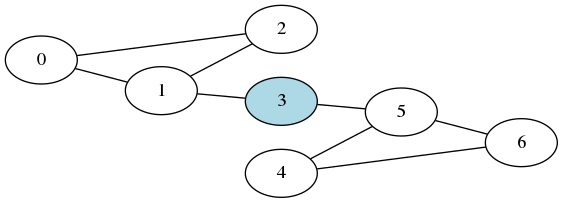

In [17]:
g_triangle = {
    0: {1, 2},
    1: {0, 2},
    2: {0, 1},
    3: {1, 5},
    4: {5, 6},
    5: {4, 6},
    6: {4, 5},
}

G_triangle = nx.from_dict_of_lists(g_triangle)
G_triangle.graph['rankdir'] = 'LR'
gt.color_nodes(G_triangle, [3], 'lightblue')
nxpd.draw(G_triangle, show='ipynb')

**Exercise:** What is the degree centrality of the highlighted node?

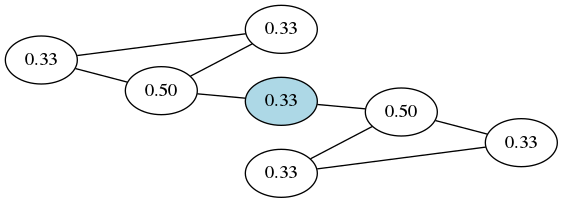

In [18]:
degree_centralities = gt.format_dict_of_floats(nx.degree_centrality(G_triangle))
gt.label_nodes(G_triangle, degree_centralities)
nxpd.draw(G_triangle, show='ipynb')

The breadth first search algorithm can be used to efficiently calculate the number of the number of shortest paths through a given node.

$$\sigma_{uv} = \text{# of shortest paths between u and v}$$
$$\sigma_{uv}(w) = \text{# of shortest paths between u and v that pass through w}$$

The *betweenness centrality* of a node measures how often we need to pass through the node to move around the graph

$$\text{betweenness_centrality}(w) = \sum_{u \neq w, v \neq w} \frac{ \sigma_{uv}(w) }{ \sigma_{uv} }$$

The *normalized betweenness centrality* is:

$$\frac{ \text{betweenness_centrality}(w) }{ \frac{(n-1)(n-2)}{2} }$$

**Question:** Whats with the denominator?

**Activity:** Compute the betweenness centrality of all the nodes in the two triangle graph.

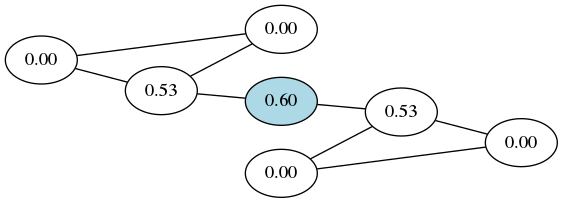

In [19]:
between_centralities = gt.format_dict_of_floats(nx.betweenness_centrality(G_triangle))
gt.label_nodes(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')

We will also see later that the concept of betweenness centrality can also be applies to edges in the graph, resulting in cool pictures like this:

![Roads Betweeness Centrality](images/edge-betweeness.png)

### Eigenvector Centrality

Suppose we try to invent a centrality measure that satisfies the following appealing property

> The centrality of a node $v$ is always equal to the sum of the centralities of its neighbours.

or, a little more clearly

> A node is important if it is linked to other important nodes

If $A$ is the adjacency matrix of a graph, and $x$ is the vector containing our postulated centrality measures, we can be express this idea as system of linear equations

$$x_i = \sum_j A_{ij} x_j$$

or, as the single matrix equation

$$x = A x$$

This matrix equation may *not* have solutions, but the similar eigenvector equation does

$$Ax = \lambda x$$

If we take $\lambda_{max}$, the *largest* eigenvalue of $A$, then the solution vector $x$ *defines* the **eigenvector centrality** of our graph.

$$A x_{\text{eigenvector centrality}} = \lambda_{\text{max}} x_{\text{eigenvector centrality}}$$

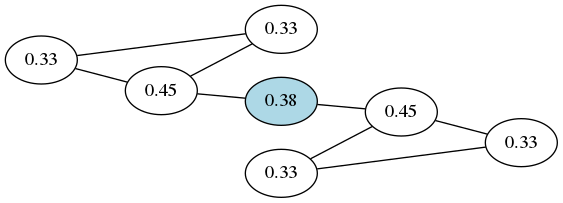

In [20]:
eigen_centralities = gt.format_dict_of_floats(nx.eigenvector_centrality(G_triangle))
gt.label_nodes(G_triangle, eigen_centralities)
nxpd.draw(G_triangle, show='ipynb')

Here's a picture from wikipedia that shows the concept a bit more clearly.

![Eigenvector Centrality](images/eigenvector-centrality.png)

**Note:** Eigenvector centrality was a fundamental component of early versions of *page rank*, Google's web page ranking algorithm.

**Discussion:** Recap and contrast the type of information the different centrality measures we learned can give you.

Which centrality measure would you use to...
* Find a twitter user who is popular?
* Find a twitter user who is important in multiple fields?
* Find a twitter user who is influential?

### Communities

![Simple Communities](images/simple-communities.jpg)

Formally a **community** is a subset of the nodes in a graph.  We say a graph is *partitioned into communities* if each node is assigned to exactly one community. 

We would like to create communities so that the following vague idea is true:

> Points in the *same* community are more likely to have an edge between them than points in *different* communities.

Just like in clustering, we need a way to *measure* how true this is for a given partition.

### Modularity

The "goodness" of a partition into communities is measured by *modularity*, which is a somewhat tricky concept.

In [25]:
def make_nbhd_graph(x, y, D):
    G = nx.Graph()
    G.add_nodes_from(zip(x, y))
    for ((x_1, y_1), (x_2, y_2)) in product(zip(x, y), zip(x, y)):
        if (x_1 - x_2)**2 + (y_1 - y_2)**2 <= D:
            G.add_edge((x_1, y_1), (x_2, y_2))
    return G

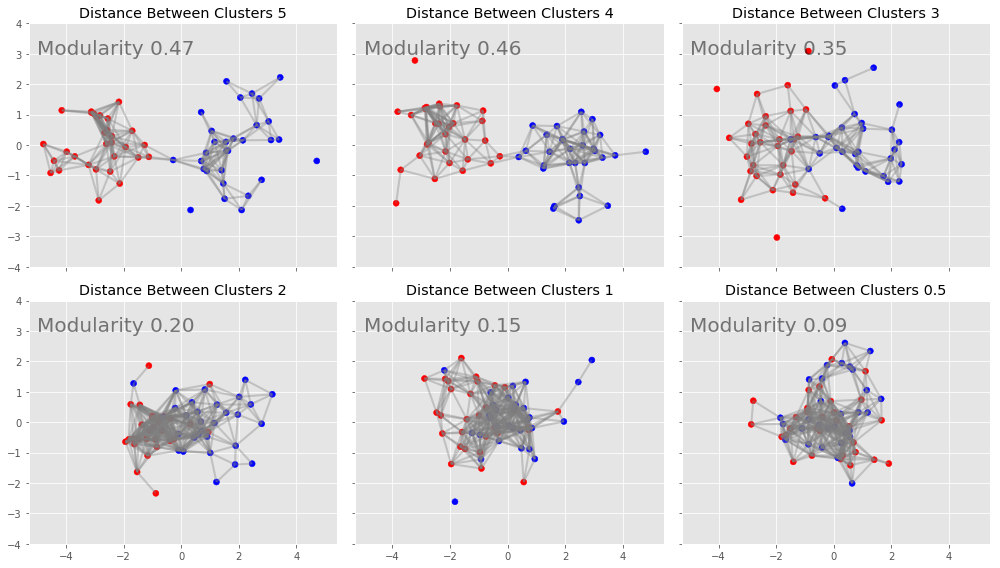

In [26]:
ds = [5, 4, 3, 2, 1, 0.5]

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

for d, ax in zip(ds, axs.flatten()):
    x, y = make_two_clusters(30, d)
    ax.scatter(x, y, color=(["red"]*30 + ["blue"]*30))
    ax.set_title("Distance Between Clusters {}".format(d))

    lc = make_segments_in_nbhd_graph(x, y, 1.5)
    ax.add_collection(lc)

    G = make_nbhd_graph(x, y, d)
    communities = {(x[i], y[i]): i < 30 for i in range(30*2)}
    modularity = community.modularity(communities, G)
    ax.text(-5, 3, "Modularity {0:2.2f}".format(modularity), fontsize=20, alpha=0.5)
    ax.set_ylim(-6, 6)
    ax.set_ylim(-4, 4)

plt.tight_layout()

The *idea* of modularity is to compare the graph we have to what we would expect if we erased the actual edges and drew *random* edges in their place.


Imagine taking a graph and removing the middle of each edge. You'd end up with a bunch of nodes with edge stubs sticking out. If $m$ is the original number of edges, we now have $2m$ stubs. Each node $i$ has $d(i)$ stubs coming out, where $d(i)$ is the degree of node $i$

![](images/edge_stubs.png)

Now randomly connect the stubs together. We can calculate the probability that node $i$ gets connected to node $j$

$$
\begin{align}
\text{P}(\text{single edge stub gets connected to }j) & = \frac{d(j)}{2m} \\
\text{Expected number of edges from }i\text{ to }j & = \frac{d(i)d(j)}{2m} \\
\text{Expected number of edges between nodes within one community} & = \sum_{i,j \in C} \frac{d(i)d(j)}{2m}
\end{align}
$$

The **modularity** of a partitioning of a graph $G$ into a set of communities $\mathcal{C}$ is defined as the *true* number of edges within communities minus the *expected* number of edges under this random edge assignment (all divided by $2m$)

$$
\text{modularity}(G,\mathcal{C}) = \frac{1}{2m}\sum_{C\in\mathcal{C}}\left[\sum_{i,j\in C}\left(A_{ij} - \frac{d(i)d(j)}{2m}\right)\right]
$$

Where $A_{ij}$ is the entry in the adjacency matrix: $1$ if nodes $i$ and $j$ are connected, $0$ if not.

Modularity (also called [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity)) can range from -1 to 1


### Creating Communities

Now that we can measure how good a breakdown into communities is (using modularity) we need an algorithm to create communities for us.

**Inspiration:** If our graph breaks up into *disconnected* pieces, these are certainly good communities.

**Idea:** Remove the *minimal* number of edges needed to break the graph into disconnected pieces.  The resulting pieces should be good communities.

Here we can remove the grey edges, and the resulting communities are all colored.

![Simple Communities](images/simple-communities.jpg)

How can we identify the grey edges if

- The graph was not draws so suggestively
- Nothing was colored

**Discussion:** Brainstorm.  How should we identify the edges to remove?

### Betweenness Centrality Redux

Earlier, we defined the **betweenness centrality** measure of a *node* as the number of shorted paths that must pass through that node.

This idea could equally well apply to *edges*!

![Roads Betweeness Centrality](images/edge-betweeness.png)

The **betweenness centrality** of an edge $e$ is:

$$\text{betweenness_centrality}(e) = \sum_{u \neq v} \frac{ \sigma_{uv}(e) }{ \sigma_{uv} }$$

Where the $\sigma$s have the same meaning as before:

$$\sigma_{uv} = \text{# of shortest paths between u and v}$$
$$\sigma_{uv}(w) = \text{# of shortest paths between u and v that pass through e}$$

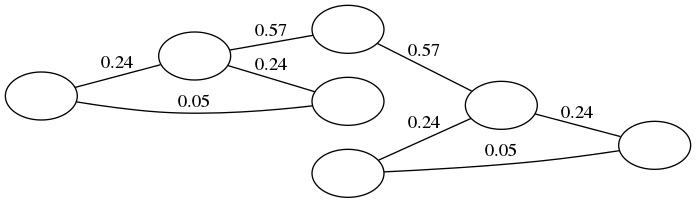

In [27]:
between_centralities = gt.format_dict_of_floats(nx.edge_betweenness_centrality(G_triangle))
gt.reset_graph(G_triangle)
gt.label_edges(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')

### Girvan-Newman Algorithm

The **Girvan-Newman** algorithm is a simple way to break a graph down into communities.

    Repeat until satisfied (i.e., you've found a partition that maximizes modularity):
        Repeat until a new connected component is created:
            Compute the edge betweenness centrality of the current graph.
            Remove the edge with highest betweenness centrality.
        Return the connected components of resulting graph as community labels.

In [28]:
# Re-defining so we get some node labels
g_triangle = {
    0: {1, 2},
    1: {0, 2},
    2: {0, 1},
    3: {1, 5},
    4: {5, 6},
    5: {4, 6},
    6: {4, 5},
}

G_triangle = nx.from_dict_of_lists(g_triangle)
G_triangle.graph['rankdir'] = 'LR'

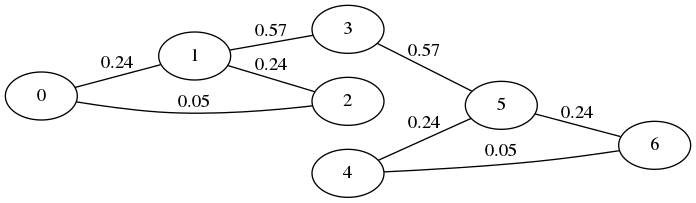

In [29]:
between_centralities = gt.format_dict_of_floats(nx.edge_betweenness_centrality(G_triangle))
gt.label_edges(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')

In [30]:
G_triangle.remove_edge(1, 3)

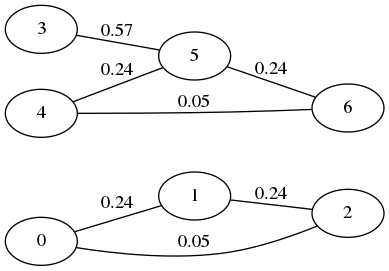

In [31]:
nxpd.draw(G_triangle, show='ipynb')

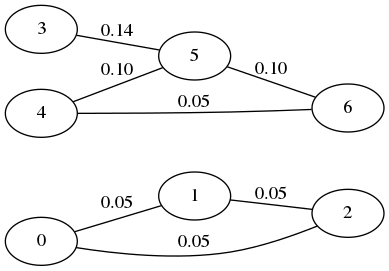

In [32]:
between_centralities = gt.format_dict_of_floats(nx.edge_betweenness_centrality(G_triangle))
gt.label_edges(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')

In [33]:
G_triangle.remove_edge(3, 5)

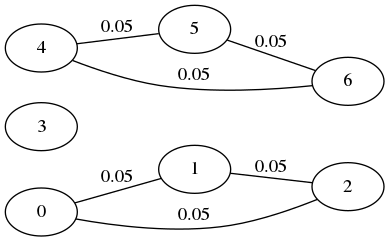

In [34]:
between_centralities = gt.format_dict_of_floats(nx.edge_betweenness_centrality(G_triangle))
gt.label_edges(G_triangle, between_centralities)
nxpd.draw(G_triangle, show='ipynb')